In [8]:
import numpy as np #importing packages
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset
from plotting import loss_plots, plot_random_images, plot_image_comparison
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [54]:
tf = transforms.Compose([
    # transforms.ToPILImage(),
    # transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1))
])

data_train = OwnDataset(train=True, transform=tf)
data_test = OwnDataset(train=False, transform=tf)

train_loader = DataLoader(data_train, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(data_test, batch_size=64, shuffle=True, pin_memory=cuda)



In [72]:
# get a sample image from the dataset
sample = data_train[612][0]
sample.shape

sample.reshape((68,68,3))

sample.shape

torch.Size([3, 68, 68])

In [50]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 3, 68, 68]) torch.Size([64])


In [53]:
# show image

x[0]

# turn to rgb 255
x_temp = (x[32] / x[32].max() * 255).int()

x_temp.shape

# plt.imshow(x_temp.permute(1, 2, 0).numpy())

torch.Size([3, 68, 68])

# VAE

In [11]:
from models import VAE_CELL_linear
from loss_functions import loss_function

model = VAE_CELL_linear(input_dim=68*68*3, hidden_dim=512, latent_dim=2)
print(model)

if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3)


VAE_CELL_linear(
  (encoder): Sequential(
    (0): Linear(in_features=13872, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
  )
  (mu): Linear(in_features=512, out_features=2, bias=True)
  (sigma): Linear(in_features=512, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=13872, bias=True)
    (5): Sigmoid()
  )
)


In [12]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat, mu, sigma = output
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([64, 13872])
x_hat.shape: torch.Size([64, 13872])


## Training

In [13]:
num_epochs = 100

train_loss = []
train_mse_loss = []
train_kld_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        x_hat, mu, sigma = model(x)
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}")




Epoch 1/100, loss: 75465.62939453125, mse: 75280.2375637755, kld: 185.39161042200058
Epoch 2/100, loss: 74639.25529137436, mse: 74635.35294762436, kld: 3.902093565585662
Epoch 3/100, loss: 74624.36154735331, mse: 74611.4172911352, kld: 12.944392746808578
Epoch 4/100, loss: 74743.70822704081, mse: 74649.62425263075, kld: 94.08396295503694
Epoch 5/100, loss: 74560.47908362564, mse: 74530.50085698342, kld: 29.97858965153597
Epoch 6/100, loss: 74497.86261360013, mse: 74439.10471141581, kld: 58.75811568085028
Epoch 7/100, loss: 74458.24170918367, mse: 74388.58668486925, kld: 69.65491913776009
Epoch 8/100, loss: 74442.17646882973, mse: 74366.1094547194, kld: 76.06681722524215
Epoch 9/100, loss: 74420.76450892857, mse: 74340.80500637754, kld: 79.95961343025675
Epoch 10/100, loss: 74417.96077806123, mse: 74336.57343152104, kld: 81.38754517691476
Epoch 11/100, loss: 74407.51492745536, mse: 74320.84449736925, kld: 86.67070928885012
Epoch 12/100, loss: 74390.1161312181, mse: 74302.28622249681, kl

## Plots

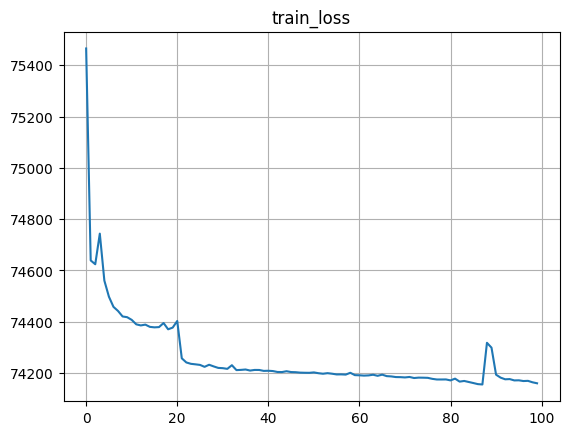

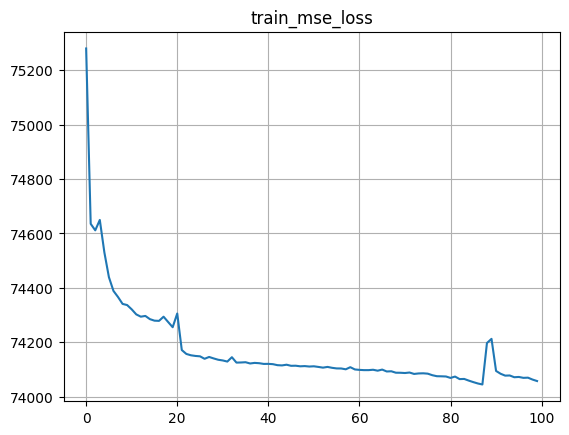

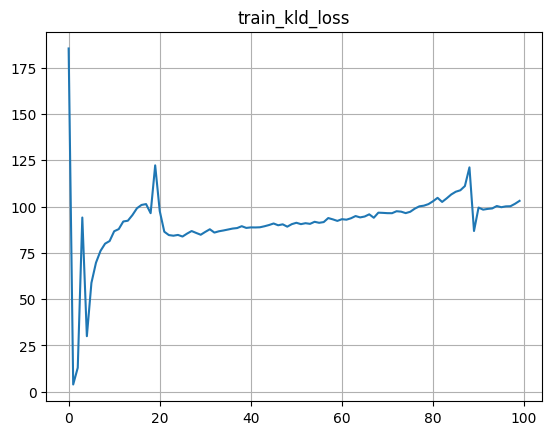

In [20]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["train_mse_loss"] = train_mse_loss
loss_data["train_kld_loss"] = train_kld_loss


loss_plots(loss_data, invidual_plots=True)

TypeError: Invalid shape (3, 68, 68) for image data

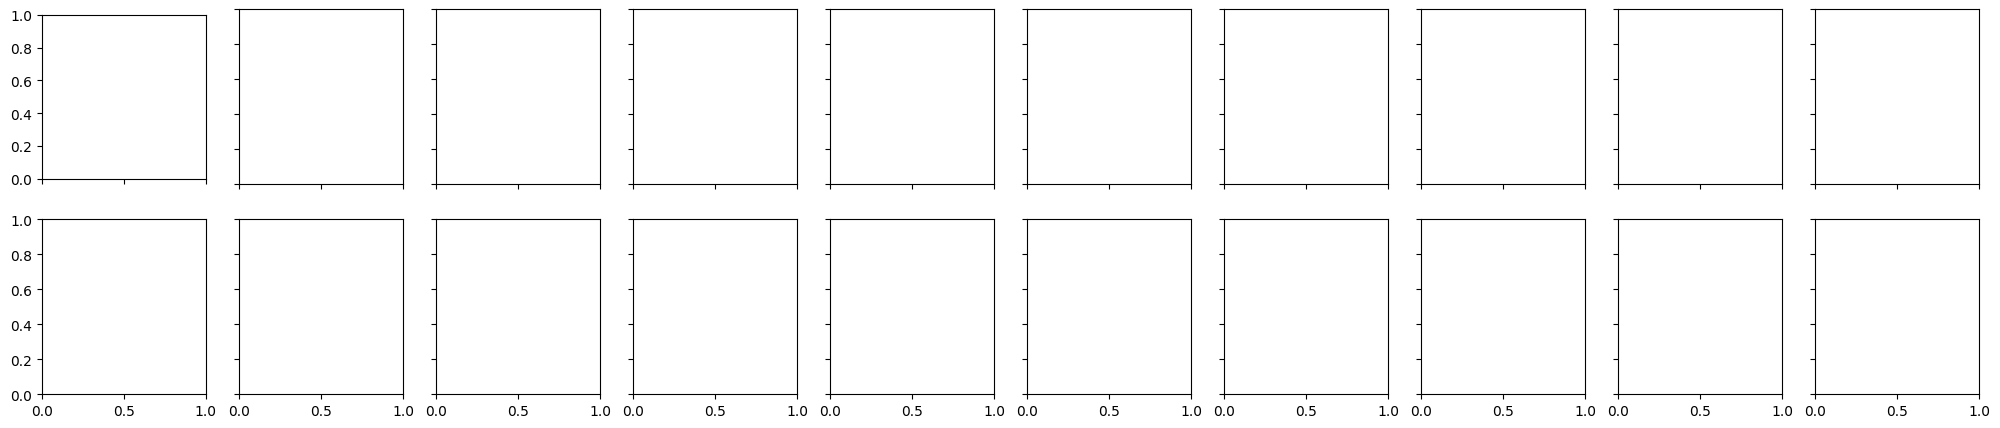

In [23]:
# test the model
plot_image_comparison(model, test_loader, cuda, img_shape=(3, 68, 68))

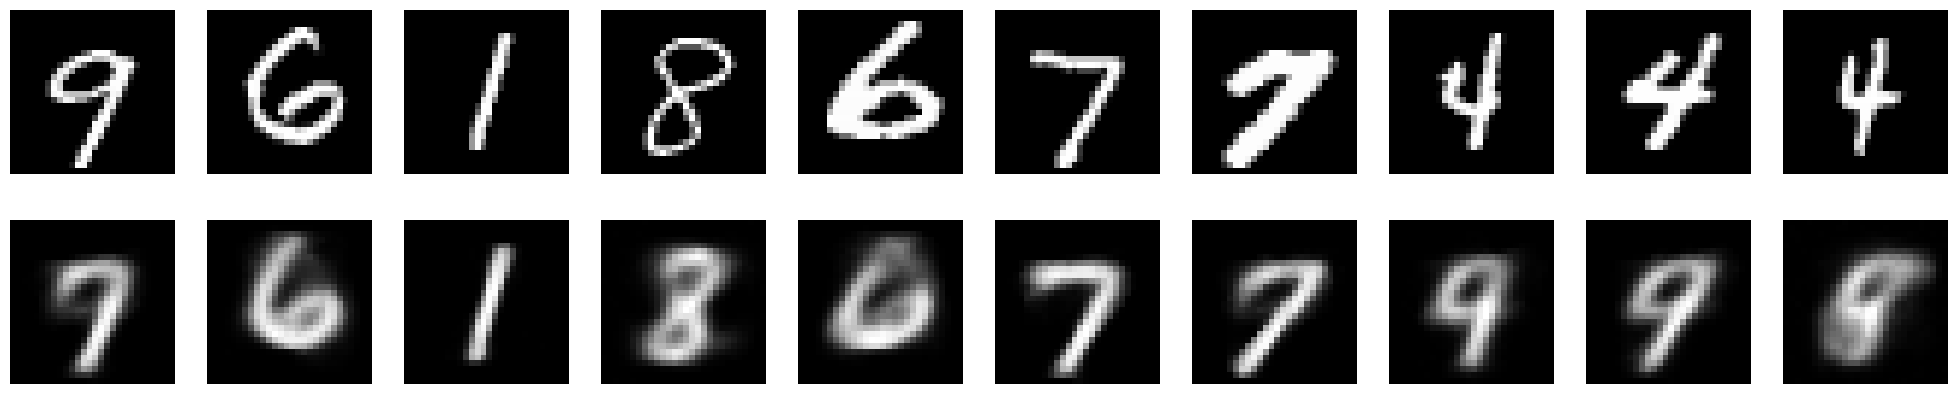

In [ ]:
# generate new images using decoder
plot_image_comparison(model, test_loader, cuda)

In [ ]:
from inference import Inference

inference = Inference(model, test_loader)

In [ ]:
samples = inference.samples